Introduction
============
**Topic**: Setting up a simple 2D - Environment for testing "collisions".

This is an early version of an interactive work-sheet regarding "Introduction to path planning".

Version | Author      | active
------- | ----------- | ------
0.3     | Björn Hein  | no
0.4     | Paul Glaser | yes

One goal of the notebook series is to discuss and implement algorithms for collision-free path planning. Therefore an concept is needed, to represent and indicate obstacles during search. This notebook will give an hint how to implement such an "environment" in a very simple way using an python library called **Shapely**.

License is based on Creative Commons: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) (pls. check: http://creativecommons.org/licenses/by-nc/4.0/)

Important links are:

* General Info: http://www.python.org
* NetworkX http://networkx.github.io/
* NumPy and SciPy Guide http://docs.scipy.org/
* Matplotlib gallery https://matplotlib.org/stable/



**Fehler bei shapely/descartes: Mit pip install --force-reinstall -v "shapely==1.8.5.post1" lässt sich die zur aktuellen descartes versioni kompatible Shapely-Variante installieren.**

# Goal

* Understanding how to set up a 2D testing Environment
* Understanding hot to visualizing the environment
* Understanding how to set up a collision checker for the path planning algorithms



Set up the Environment
======================

The planning will take place in a certain environment. For testing it is sometimes useful to simplify the environment, e.g. taking a simple 2D approach.

**Remember**: Even if the obstacles will be "visible", all our investigated algorithms have to assume, that these **obstacles are not visible (not explicitly computable)**, but have to be detected during search (implicit configuration space).



As proposal the 2D-Python library Shapely seems to be a good choice (https://pypi.python.org/pypi/Shapely).

Shapely is a BSD-licensed Python package for manipulation and analysis of planar geometric objects. It is based on the widely deployed GEOS (the engine of PostGIS) and JTS (from which GEOS is ported) libraries.

Shapely provides much more functionality than needed. In the context of the lecture it will be used to test different geometric objects for collision.



Idea
-----

The idea is to use the functionality provided by shapely and programmatically define the environemnt.

In [32]:
import matplotlib.pyplot as plt
#%matplotlib notebook

# use following for pdf generation
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from shapely import plotting

import numpy as np

Defining a scene
-----------------

1. Definition of obstacles via polygons. 
2. As storage a dict is proposed containing then the "scene"

In [2]:
simpleField = dict()
simpleField["obs1"] = Polygon([(6, 14), (13, 14), (13, 11), (6,11)]).buffer(2.0)
simpleField["obs2"] = Polygon([(16, 5), (19, 5), (19, 3),(16,3)]).buffer(1.0)

Based on that scene definition a simple viszalization function can be written:

In [3]:
def drawScene(content, limits=[[0,23],[0,23]], figsize=(10,10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    for key, value in content.items():
        plotting.plot_polygon(value, add_points=False)
        

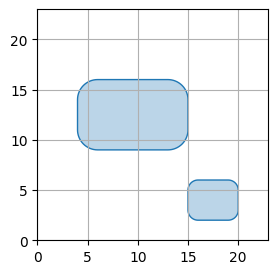

In [4]:
drawScene(simpleField, figsize=(3,3))

In [5]:
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1)

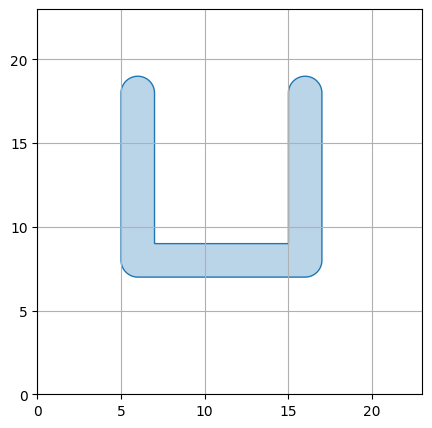

In [6]:
drawScene(trapField, figsize=(5,5))

For a more complicated example see:


In [7]:
special = dict()
special["base"] = LineString([(11,0),(11,18)]).buffer(0.5)
for i in range(15):
    target1 = (11-0.5*i,18-i)
    target2 = (11+0.5*i,18-i)
    special["partA"+str(i)] = LineString([(11,18-i), target1 ]).buffer(0.2)
    special["partB"+str(i)] = LineString([(11,18-i), target2 ]).buffer(0.2)
    if i % 2 == 0:
        special["candA"+str(i)] = LineString([target1, (target1[0], target1[1]+1.5)]).buffer(0.05)
        special["candB"+str(i)] = LineString([target2, (target2[0], target2[1]+1.5)]).buffer(0.05)

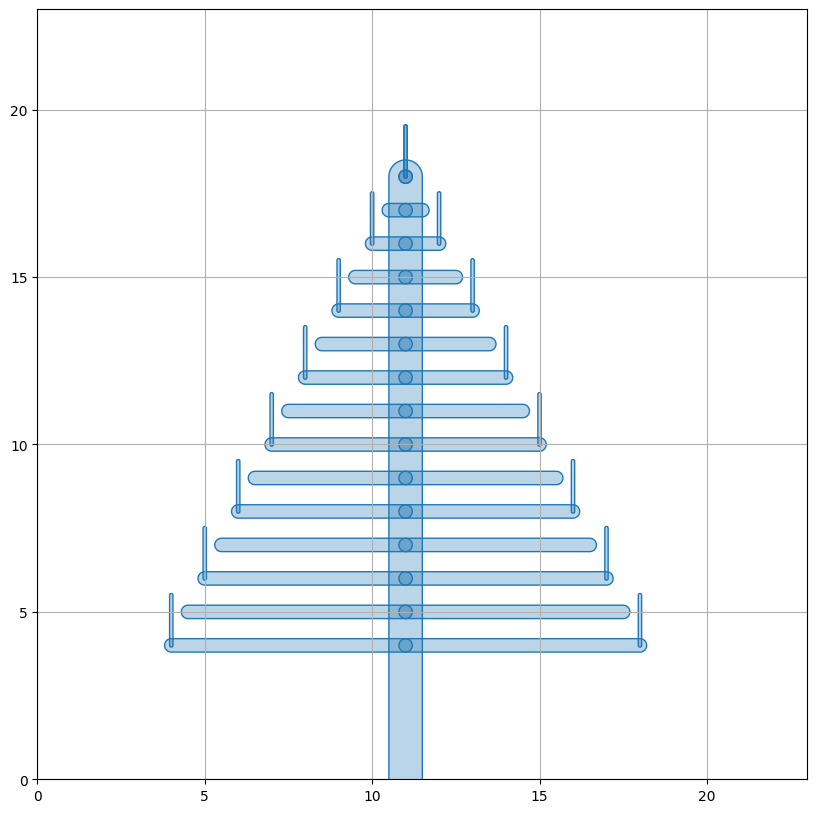

In [8]:
drawScene(special)

Collision checking
=================

One advantage of using shapely is the ability to easily check geometric objects for **intersection** and **distance**.

Point - Point
---------------

In [25]:
object1 = Point([15,5]).buffer(0.3)
object2 = Point([10,5]).buffer(4.)

print(object1.intersects(object2))
print(object1.distance(object2))

False
0.6999999999999993


In [26]:
scene = dict()
scene["ob1"] = object1
scene["ob2"] = object2

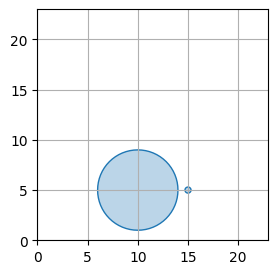

In [27]:
drawScene(scene, figsize=(3,3))

Point-Line example
-----------------------

In [28]:
lineScene = dict()
lineScene["point"] = Point([10,5]).buffer(1.0).buffer(1.0)
lineScene["ob2"] = LineString([[1,2],[10,10]]).buffer(.1)

print(lineScene["point"].intersects(lineScene["ob2"]))
print(lineScene["point"].distance(lineScene["ob2"]))


False
1.6378701585180127


In [29]:
for key, obj in lineScene.items():
    print(key)

point
ob2


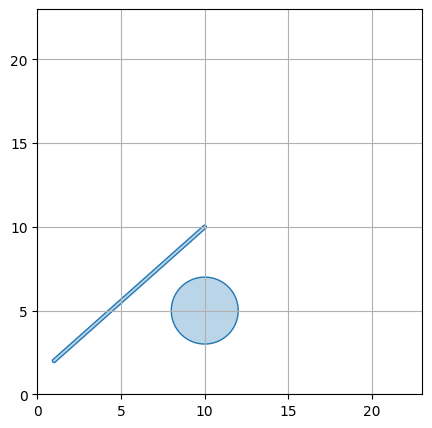

In [30]:
drawScene(lineScene, figsize=(5,5))

Definition of an CollisionChecker
===================================

Following a proposal for a collision checker based on Shapely.

In [33]:
class CollisionChecker(object):

    def __init__(self, scene, limits = [[0.0,22.0],[0.0,22.0]], statistic = None):
        self.scene = scene
        self.limits = limits
        
    def getDim(self):
        """ Return dimension of Environment (Shapely should currently always be 2)"""
        return 2
    
    def getEnvironmentLimits(self):
        """ Return limits of Environment"""
        return list(self.limits)

    def pointInCollision(self, pos):
        """ Return whether a configuration is
        inCollision -> True
        Free -> False """
        assert(len(pos)==self.getDim())
        for key, value in self.scene.items():
            if value.intersects(Point(pos[0],pos[1])):              
                return True
        return False

    def lineInCollision(self, startPos, endPos):
        """ Check whether a line from startPos to endPos is colliding"""
        assert(len(startPos)==self.getDim())
        assert(len(endPos)==self.getDim())
       
        # ===== OLD VERSION >>>>> #
        # for key, value in self.scene.items():
        #     if value.intersects(LineString([(startPos[0],startPos[1]),(endPos[0],endPos[1])])):
        #         return True
        # return False
        # <<<<< OLD VERSION ===== #
    
        # ===== NEW VERSION (from IPEnvironment.py) >>>>> #
        p1 = np.array(startPos)
        p2 = np.array(endPos)
        p12 = p2-p1
        k = 40
        #print("testing")
        for i in range(k):
            testPoint = p1 + (i+1)/k*p12
            if self.pointInCollision(testPoint)==True:
                return True
        return False
        # <<<<< NEW VERSION (from IPEnvironment.py) ===== #
    
    def drawObstacles(self, ax):
        for key, value in self.scene.items():
            plotting.plot_polygon(value, add_points=False, ax=ax)

Testing and using the collision checker
------------------------------------------

In [34]:
lineScene = dict()
lineScene["point"] = Point([10,5]).buffer(1.0).buffer(1.0)
lineScene["ob2"] = LineString([[1,2],[10,10]]).buffer(1.0)


In [35]:
cc = CollisionChecker(lineScene)

As the drawing function is now part of the collision checker, the figure and draw area has to be defined beforehand.

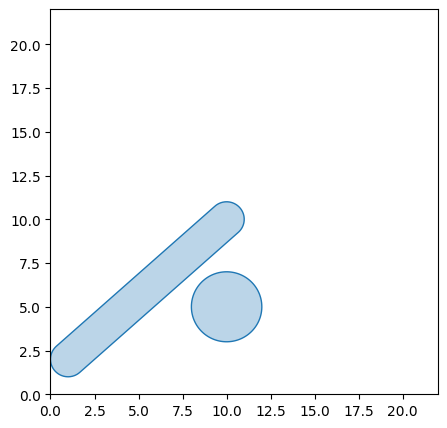

In [36]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
limits = cc.getEnvironmentLimits()
ax.set_xlim(limits[0])
ax.set_ylim(limits[1])

cc.drawObstacles(ax)

In [37]:
print(cc.pointInCollision([10,10]))
print(cc.pointInCollision([2,5]))

True
False


In [38]:
print(cc.lineInCollision([5,0],[5,10]))
print(cc.lineInCollision([5,0],[10,0]))

True
False


In [21]:
<szenenName> = dict()
<szenenName>["obs1"] = Polygon([(0, 8), (11, 8),(11, 15), (0, 15)]).buffer(.5)
<szenenName>["obs2"] = Polygon([(13, 8), (24, 8),(24, 15), (13, 15)]).buffer(.5)
description = "Planer has to find a narrow passage with a significant extend."
benchList.append(Benchmark("aName", CollisionChecker(<szenenName>), [[4,21]], [[18,1]], description, 2))

SyntaxError: invalid syntax (3750457847.py, line 1)

In [ ]:
import IPTestSuite as ts
import matplotlib.pylab as plt

In [ ]:
for i in ts.benchList:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1,1,1)
    limits = i.collisionChecker.getEnvironmentLimits()
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    i.collisionChecker.drawObstacles(ax)